In [ ]:
import pandas as pd
from scripts.pyensembl_operations import import_pyensembl
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.misc import *

# Initialize pyensembl
g37 = import_pyensembl(37)
pd.set_option('display.max_columns', None)   # Show all columns

real, df = prepare_breast_cancer_data(
    counts_file="results/last/040/counts_025filter_sig778_adj29.csv",
    results_db="results.db",
    genes_db="data/mirscribe.db"
)

overview = df[df.is_brca_driver & df.is_significant][["gene_name", "gene_id", "is_gene_upregulated", "is_oncogene", "is_tsupp", "result", "log2_odds_ratio"]].sort_values(by="result", ascending=False)
# filling in is_tsupp manually
overview.loc[overview.gene_name == "BRCA1", "is_tsupp"] = True
overview.loc[overview.gene_name == "RB1", "is_tsupp"] = True
overview.loc[overview.gene_name == "PIK3R1", "is_tsupp"] = True
overview.loc[overview.gene_name == "CSMD3", "is_tsupp"] = True
overview.loc[overview.gene_name == "ATP2B3", "is_tsupp"] = True

merged_df = real.merge(overview, on='gene_id', suffixes=('', '_overview'))
merged_df['is_dual'] = merged_df['is_oncogene'] & merged_df['is_tsupp']

INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/nazif/thesis/data/pyensembl/GRCh37/ensembl75/Homo_sapiens.GRCh37.75.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/nazif/thesis/data/pyensembl/GRCh37/ensembl75/Homo_sapiens.GRCh37.75.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/nazif/thesis/data/pyensembl/GRCh37/ensembl75/Homo_sapiens.GRCh37.75.pep.all.fa.gz.pickle


In [98]:
def plot_gene_distribution(merged_df):
    """
    Plot distribution of gene categories by Mutsig, including 'other' genes.
    X-axis is sorted by total counts.
    """
    # Create flags for dual-role genes
    merged_df['is_dual'] = merged_df['is_oncogene'] & merged_df['is_tsupp']

    # Separate single-role genes
    upreg_oncogenes = merged_df[(merged_df.is_oncogene) & (~merged_df.is_dual) & (merged_df.log2_odds_ratio > 0)]
    downreg_tsupps = merged_df[(merged_df.is_tsupp) & (~merged_df.is_dual) & (merged_df.log2_odds_ratio < 0)]
    downreg_oncogenes = merged_df[(merged_df.is_oncogene) & (~merged_df.is_dual) & (merged_df.log2_odds_ratio < 0)]
    upreg_tsupps = merged_df[(merged_df.is_tsupp) & (~merged_df.is_dual) & (merged_df.log2_odds_ratio > 0)]

    # Handle dual-role genes separately
    upreg_dual = merged_df[merged_df.is_dual & (merged_df.log2_odds_ratio > 0)]
    downreg_dual = merged_df[merged_df.is_dual & (merged_df.log2_odds_ratio < 0)]

    # Handle other genes (neither oncogene nor tumor suppressor)
    upreg_other = merged_df[
        (~merged_df.is_oncogene) & (~merged_df.is_tsupp) & (merged_df.log2_odds_ratio > 0)
    ]
    downreg_other = merged_df[
        (~merged_df.is_oncogene) & (~merged_df.is_tsupp) & (merged_df.log2_odds_ratio < 0)
    ]

    # Calculate total counts for sorting
    total_counts = pd.concat([
        upreg_oncogenes['mutsig'], downreg_tsupps['mutsig'],
        upreg_tsupps['mutsig'], downreg_oncogenes['mutsig'],
        upreg_dual['mutsig'], downreg_dual['mutsig'],
        upreg_other['mutsig'], downreg_other['mutsig']
    ]).value_counts()

    # Get sorted mutsigs
    sorted_mutsigs = total_counts.index

    # Helper function to get counts with consistent index
    def get_counts(df):
        return df['mutsig'].value_counts().reindex(sorted_mutsigs).fillna(0)

    # Plotting
    plt.figure(figsize=(15, 6))
    x = np.arange(len(sorted_mutsigs))
    width = 0.15

    # Stack the greens (harmful changes)
    plt.bar(x, get_counts(upreg_oncogenes), width, 
            label='Upregulated Oncogenes', color='#00ff00')
    plt.bar(x, get_counts(downreg_tsupps), width, 
            label='Downregulated Tumor Suppressors', color='#004d00',
            bottom=get_counts(upreg_oncogenes))

    # Stack the reds (beneficial changes)
    plt.bar(x + width, get_counts(upreg_tsupps), width,
            label='Upregulated Tumor Suppressors', color='#ff0000')
    plt.bar(x + width, get_counts(downreg_oncogenes), width,
            label='Downregulated Oncogenes', color='#800000',
            bottom=get_counts(upreg_tsupps))

    # Add dual-role genes with purple colors
    plt.bar(x + 2*width, get_counts(upreg_dual), width,
            label='Upregulated Dual-Role', color='#800080')
    plt.bar(x + 2*width, get_counts(downreg_dual), width,
            label='Downregulated Dual-Role', color='#4B0082',
            bottom=get_counts(upreg_dual))

    # Add other genes with gray colors
    plt.bar(x + 3*width, get_counts(upreg_other), width,
            label='Upregulated Other', color='#808080')
    plt.bar(x + 3*width, get_counts(downreg_other), width,
            label='Downregulated Other', color='#404040',
            bottom=get_counts(upreg_other))

    plt.xlabel('Mutsig')
    plt.ylabel('Count')
    plt.title('Distribution of Gene Categories by Mutsig\n(Sorted by Total Counts)')
    plt.xticks(x + 1.5*width, sorted_mutsigs, rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_mutsig_distribution_both():
    """
    Plot distribution of gene categories by mutsig showing both supporting and contradicting genes,
    with x-axis sorted by total counts. Includes genes that are neither oncogenes nor tumor suppressors.
    """
    # Create flags for dual-role genes
    merged_df['is_dual'] = merged_df['is_oncogene'] & merged_df['is_tsupp']
    
    # Function to get data for a specific result type and category
    def get_category_data(result_type, is_onc, is_ts, is_dual, log2or_condition):
        if is_onc is None and is_ts is None:  # For "other" genes
            return merged_df[
                (merged_df.result == result_type) & 
                (~merged_df.is_oncogene) & 
                (~merged_df.is_tsupp) &
                log2or_condition
            ]
        return merged_df[
            (merged_df.result == result_type) & 
            (merged_df.is_oncogene == is_onc) & 
            (merged_df.is_tsupp == is_ts) & 
            (merged_df.is_dual == is_dual) & 
            log2or_condition
        ]
    
    # Get data for supports
    s_upreg_oncogenes = get_category_data("supports", True, False, False, merged_df.log2_odds_ratio > 0)
    s_downreg_tsupps = get_category_data("supports", False, True, False, merged_df.log2_odds_ratio < 0)
    s_upreg_tsupps = get_category_data("supports", False, True, False, merged_df.log2_odds_ratio > 0)
    s_downreg_oncogenes = get_category_data("supports", True, False, False, merged_df.log2_odds_ratio < 0)
    s_upreg_dual = get_category_data("supports", True, True, True, merged_df.log2_odds_ratio > 0)
    s_downreg_dual = get_category_data("supports", True, True, True, merged_df.log2_odds_ratio < 0)
    s_upreg_other = get_category_data("supports", None, None, False, merged_df.log2_odds_ratio > 0)
    s_downreg_other = get_category_data("supports", None, None, False, merged_df.log2_odds_ratio < 0)

    # Get data for contradicts
    c_upreg_oncogenes = get_category_data("contradicts", True, False, False, merged_df.log2_odds_ratio > 0)
    c_downreg_tsupps = get_category_data("contradicts", False, True, False, merged_df.log2_odds_ratio < 0)
    c_upreg_tsupps = get_category_data("contradicts", False, True, False, merged_df.log2_odds_ratio > 0)
    c_downreg_oncogenes = get_category_data("contradicts", True, False, False, merged_df.log2_odds_ratio < 0)
    c_upreg_dual = get_category_data("contradicts", True, True, True, merged_df.log2_odds_ratio > 0)
    c_downreg_dual = get_category_data("contradicts", True, True, True, merged_df.log2_odds_ratio < 0)
    c_upreg_other = get_category_data("contradicts", None, None, False, merged_df.log2_odds_ratio > 0)
    c_downreg_other = get_category_data("contradicts", None, None, False, merged_df.log2_odds_ratio < 0)

    # Get all unique mutsig values
    all_mutsigs = pd.concat([df['mutsig'] for df in [
        s_upreg_oncogenes, s_downreg_tsupps, s_upreg_tsupps, s_downreg_oncogenes, 
        s_upreg_dual, s_downreg_dual, s_upreg_other, s_downreg_other,
        c_upreg_oncogenes, c_downreg_tsupps, c_upreg_tsupps, c_downreg_oncogenes, 
        c_upreg_dual, c_downreg_dual, c_upreg_other, c_downreg_other
    ]]).unique()

    # Calculate total counts for each mutsig to sort
    def get_counts(df, mutsigs):
        return df['mutsig'].value_counts().reindex(mutsigs).fillna(0)

    total_counts = pd.Series(0, index=all_mutsigs)
    for df in [s_upreg_oncogenes, s_downreg_tsupps, s_upreg_tsupps, s_downreg_oncogenes, 
               s_upreg_dual, s_downreg_dual, s_upreg_other, s_downreg_other,
               c_upreg_oncogenes, c_downreg_tsupps, c_upreg_tsupps, c_downreg_oncogenes, 
               c_upreg_dual, c_downreg_dual, c_upreg_other, c_downreg_other]:
        total_counts += get_counts(df, all_mutsigs)

    # Sort mutsigs by total counts
    all_mutsigs = total_counts.sort_values(ascending=False).index

    # Plotting code
    plt.figure(figsize=(15, 8))
    x = np.arange(len(all_mutsigs))
    width = 0.15

    # Plot supporting genes (above x-axis)
    plt.bar(x, get_counts(s_upreg_oncogenes, all_mutsigs), width, 
            label='Upregulated Oncogenes (S)', color='#00ff00')
    plt.bar(x, get_counts(s_downreg_tsupps, all_mutsigs), width, 
            label='Downregulated Tumor Suppressors (S)', color='#004d00',
            bottom=get_counts(s_upreg_oncogenes, all_mutsigs))

    plt.bar(x + width, get_counts(s_upreg_tsupps, all_mutsigs), width,
            label='Upregulated Tumor Suppressors (S)', color='#ff0000')
    plt.bar(x + width, get_counts(s_downreg_oncogenes, all_mutsigs), width,
            label='Downregulated Oncogenes (S)', color='#800000',
            bottom=get_counts(s_upreg_tsupps, all_mutsigs))

    plt.bar(x + 2*width, get_counts(s_upreg_dual, all_mutsigs), width,
            label='Upregulated Dual-Role (S)', color='#800080')
    plt.bar(x + 2*width, get_counts(s_downreg_dual, all_mutsigs), width,
            label='Downregulated Dual-Role (S)', color='#4B0082',
            bottom=get_counts(s_upreg_dual, all_mutsigs))

    plt.bar(x + 3*width, get_counts(s_upreg_other, all_mutsigs), width,
            label='Upregulated Other (S)', color='#808080')
    plt.bar(x + 3*width, get_counts(s_downreg_other, all_mutsigs), width,
            label='Downregulated Other (S)', color='#404040',
            bottom=get_counts(s_upreg_other, all_mutsigs))

    # Plot contradicting genes (below x-axis)
    plt.bar(x, -get_counts(c_upreg_oncogenes, all_mutsigs), width, 
            label='Upregulated Oncogenes (C)', color='#00ff00', alpha=0.5)
    plt.bar(x, -get_counts(c_downreg_tsupps, all_mutsigs), width, 
            label='Downregulated Tumor Suppressors (C)', color='#004d00', alpha=0.5,
            bottom=-get_counts(c_upreg_oncogenes, all_mutsigs))

    plt.bar(x + width, -get_counts(c_upreg_tsupps, all_mutsigs), width,
            label='Upregulated Tumor Suppressors (C)', color='#ff0000', alpha=0.5)
    plt.bar(x + width, -get_counts(c_downreg_oncogenes, all_mutsigs), width,
            label='Downregulated Oncogenes (C)', color='#800000', alpha=0.5,
            bottom=-get_counts(c_upreg_tsupps, all_mutsigs))

    plt.bar(x + 2*width, -get_counts(c_upreg_dual, all_mutsigs), width,
            label='Upregulated Dual-Role (C)', color='#800080', alpha=0.5)
    plt.bar(x + 2*width, -get_counts(c_downreg_dual, all_mutsigs), width,
            label='Downregulated Dual-Role (C)', color='#4B0082', alpha=0.5,
            bottom=-get_counts(c_upreg_dual, all_mutsigs))

    plt.bar(x + 3*width, -get_counts(c_upreg_other, all_mutsigs), width,
            label='Upregulated Other (C)', color='#808080', alpha=0.5)
    plt.bar(x + 3*width, -get_counts(c_downreg_other, all_mutsigs), width,
            label='Downregulated Other (C)', color='#404040', alpha=0.5,
            bottom=-get_counts(c_upreg_other, all_mutsigs))

    plt.xlabel('Mutsig')
    plt.ylabel('Count (Supporting above, Contradicting below)')
    plt.title('Distribution of Gene Categories by Mutsig\n(Sorted by Total Counts)')
    plt.xticks(x + 1.5*width, all_mutsigs, rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
def plot_mirna_family_distribution_both(merged_df, n=10):
    """
    Plot distribution of gene categories by miRNA family for top n families.
    Supporting genes above x-axis, contradicting below. Includes "other" genes.
    
    Parameters:
    merged_df (pd.DataFrame): Input dataframe with gene categories and miRNA families
    n (int): Number of top miRNA families to show (default: 10)
    """
    # Create flags for dual-role genes
    merged_df['is_dual'] = merged_df['is_oncogene'] & merged_df['is_tsupp']

    # Function to get data for a specific result type and category
    def get_category_data(result_type, is_onc, is_ts, is_dual, log2or_condition):
        if is_onc is None and is_ts is None:  # For "other" genes
            return merged_df[
                (merged_df.result == result_type) & 
                (~merged_df.is_oncogene) & 
                (~merged_df.is_tsupp) &
                log2or_condition
            ]
        return merged_df[
            (merged_df.result == result_type) & 
            (merged_df.is_oncogene == is_onc) & 
            (merged_df.is_tsupp == is_ts) & 
            (merged_df.is_dual == is_dual) & 
            log2or_condition
        ]

    # Get data for supports
    s_upreg_oncogenes = get_category_data("supports", True, False, False, merged_df.log2_odds_ratio > 0)
    s_downreg_tsupps = get_category_data("supports", False, True, False, merged_df.log2_odds_ratio < 0)
    s_upreg_tsupps = get_category_data("supports", False, True, False, merged_df.log2_odds_ratio > 0)
    s_downreg_oncogenes = get_category_data("supports", True, False, False, merged_df.log2_odds_ratio < 0)
    s_upreg_dual = get_category_data("supports", True, True, True, merged_df.log2_odds_ratio > 0)
    s_downreg_dual = get_category_data("supports", True, True, True, merged_df.log2_odds_ratio < 0)
    s_upreg_other = get_category_data("supports", None, None, False, merged_df.log2_odds_ratio > 0)
    s_downreg_other = get_category_data("supports", None, None, False, merged_df.log2_odds_ratio < 0)

    # Get data for contradicts
    c_upreg_oncogenes = get_category_data("contradicts", True, False, False, merged_df.log2_odds_ratio > 0)
    c_downreg_tsupps = get_category_data("contradicts", False, True, False, merged_df.log2_odds_ratio < 0)
    c_upreg_tsupps = get_category_data("contradicts", False, True, False, merged_df.log2_odds_ratio > 0)
    c_downreg_oncogenes = get_category_data("contradicts", True, False, False, merged_df.log2_odds_ratio < 0)
    c_upreg_dual = get_category_data("contradicts", True, True, True, merged_df.log2_odds_ratio > 0)
    c_downreg_dual = get_category_data("contradicts", True, True, True, merged_df.log2_odds_ratio < 0)
    c_upreg_other = get_category_data("contradicts", None, None, False, merged_df.log2_odds_ratio > 0)
    c_downreg_other = get_category_data("contradicts", None, None, False, merged_df.log2_odds_ratio < 0)

    # Calculate total counts for each miRNA family
    all_counts = pd.concat([df['mirna_family'] for df in [
        s_upreg_oncogenes, s_downreg_tsupps, s_upreg_tsupps, s_downreg_oncogenes, 
        s_upreg_dual, s_downreg_dual, s_upreg_other, s_downreg_other,
        c_upreg_oncogenes, c_downreg_tsupps, c_upreg_tsupps, c_downreg_oncogenes, 
        c_upreg_dual, c_downreg_dual, c_upreg_other, c_downreg_other
    ]])
    top_n_families = all_counts.value_counts().nlargest(n).index

    # Helper function to get counts
    def get_counts(df, families):
        return df['mirna_family'].value_counts().reindex(families).fillna(0)

    # Plotting
    plt.figure(figsize=(15, 8))
    x = np.arange(len(top_n_families))
    width = 0.15

    # Plot supporting genes (above x-axis)
    plt.bar(x, get_counts(s_upreg_oncogenes, top_n_families), width, 
            label='Upregulated Oncogenes (S)', color='#00ff00')
    plt.bar(x, get_counts(s_downreg_tsupps, top_n_families), width, 
            label='Downregulated Tumor Suppressors (S)', color='#004d00',
            bottom=get_counts(s_upreg_oncogenes, top_n_families))

    plt.bar(x + width, get_counts(s_upreg_tsupps, top_n_families), width,
            label='Upregulated Tumor Suppressors (S)', color='#ff0000')
    plt.bar(x + width, get_counts(s_downreg_oncogenes, top_n_families), width,
            label='Downregulated Oncogenes (S)', color='#800000',
            bottom=get_counts(s_upreg_tsupps, top_n_families))

    plt.bar(x + 2*width, get_counts(s_upreg_dual, top_n_families), width,
            label='Upregulated Dual-Role (S)', color='#800080')
    plt.bar(x + 2*width, get_counts(s_downreg_dual, top_n_families), width,
            label='Downregulated Dual-Role (S)', color='#4B0082',
            bottom=get_counts(s_upreg_dual, top_n_families))

    plt.bar(x + 3*width, get_counts(s_upreg_other, top_n_families), width,
            label='Upregulated Other (S)', color='#808080')
    plt.bar(x + 3*width, get_counts(s_downreg_other, top_n_families), width,
            label='Downregulated Other (S)', color='#404040',
            bottom=get_counts(s_upreg_other, top_n_families))

    # Plot contradicting genes (below x-axis)
    plt.bar(x, -get_counts(c_upreg_oncogenes, top_n_families), width, 
            label='Upregulated Oncogenes (C)', color='#00ff00', alpha=0.5)
    plt.bar(x, -get_counts(c_downreg_tsupps, top_n_families), width, 
            label='Downregulated Tumor Suppressors (C)', color='#004d00', alpha=0.5,
            bottom=-get_counts(c_upreg_oncogenes, top_n_families))

    plt.bar(x + width, -get_counts(c_upreg_tsupps, top_n_families), width,
            label='Upregulated Tumor Suppressors (C)', color='#ff0000', alpha=0.5)
    plt.bar(x + width, -get_counts(c_downreg_oncogenes, top_n_families), width,
            label='Downregulated Oncogenes (C)', color='#800000', alpha=0.5,
            bottom=-get_counts(c_upreg_tsupps, top_n_families))

    plt.bar(x + 2*width, -get_counts(c_upreg_dual, top_n_families), width,
            label='Upregulated Dual-Role (C)', color='#800080', alpha=0.5)
    plt.bar(x + 2*width, -get_counts(c_downreg_dual, top_n_families), width,
            label='Downregulated Dual-Role (C)', color='#4B0082', alpha=0.5,
            bottom=-get_counts(c_upreg_dual, top_n_families))

    plt.bar(x + 3*width, -get_counts(c_upreg_other, top_n_families), width,
            label='Upregulated Other (C)', color='#808080', alpha=0.5)
    plt.bar(x + 3*width, -get_counts(c_downreg_other, top_n_families), width,
            label='Downregulated Other (C)', color='#404040', alpha=0.5,
            bottom=-get_counts(c_upreg_other, top_n_families))

    plt.xlabel('miRNA Family')
    plt.ylabel('Count (Supporting above, Contradicting below)')
    plt.title(f'Distribution of Gene Categories by miRNA Family (Top {n})\nSorted by Total Counts')
    plt.xticks(x + 1.5*width, top_n_families, rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()

def plot_mutsig_distribution_subclass():
    """
    Plot distribution of gene categories by mutsig for each cancer subclass
    """
    # Create subplots - one row for each cancer subclass
    subclasses = merged_df['cancer_subclass'].unique()
    fig, axes = plt.subplots(len(subclasses), 1, figsize=(15, 6*len(subclasses)))
    
    for idx, subclass in enumerate(subclasses):
        # Filter data for current subclass
        subclass_df = merged_df[merged_df['cancer_subclass'] == subclass].copy()
        
        # Create flags for dual-role genes
        subclass_df['is_dual'] = subclass_df['is_oncogene'] & subclass_df['is_tsupp']
        
        # Function to get data for a specific result type and category
        def get_category_data(result_type, is_onc, is_ts, is_dual, log2or_condition):
            return subclass_df[
                (subclass_df.result == result_type) & 
                (subclass_df.is_oncogene == is_onc) & 
                (subclass_df.is_tsupp == is_ts) & 
                (subclass_df.is_dual == is_dual) & 
                log2or_condition
            ]
        
        # Get data for supports and contradicts
        s_upreg_oncogenes = get_category_data("supports", True, False, False, subclass_df.log2_odds_ratio > 0)
        s_downreg_tsupps = get_category_data("supports", False, True, False, subclass_df.log2_odds_ratio < 0)
        s_upreg_tsupps = get_category_data("supports", False, True, False, subclass_df.log2_odds_ratio > 0)
        s_downreg_oncogenes = get_category_data("supports", True, False, False, subclass_df.log2_odds_ratio < 0)
        s_upreg_dual = get_category_data("supports", True, True, True, subclass_df.log2_odds_ratio > 0)
        s_downreg_dual = get_category_data("supports", True, True, True, subclass_df.log2_odds_ratio < 0)

        c_upreg_oncogenes = get_category_data("contradicts", True, False, False, subclass_df.log2_odds_ratio > 0)
        c_downreg_tsupps = get_category_data("contradicts", False, True, False, subclass_df.log2_odds_ratio < 0)
        c_upreg_tsupps = get_category_data("contradicts", False, True, False, subclass_df.log2_odds_ratio > 0)
        c_downreg_oncogenes = get_category_data("contradicts", True, False, False, subclass_df.log2_odds_ratio < 0)
        c_upreg_dual = get_category_data("contradicts", True, True, True, subclass_df.log2_odds_ratio > 0)
        c_downreg_dual = get_category_data("contradicts", True, True, True, subclass_df.log2_odds_ratio < 0)

        # Get all unique mutsig values and sort by total counts
        all_mutsigs = pd.concat([df['mutsig'] for df in [
            s_upreg_oncogenes, s_downreg_tsupps, s_upreg_tsupps, s_downreg_oncogenes, s_upreg_dual, s_downreg_dual,
            c_upreg_oncogenes, c_downreg_tsupps, c_upreg_tsupps, c_downreg_oncogenes, c_upreg_dual, c_downreg_dual
        ]]).unique()

        def get_counts(df, mutsigs):
            return df['mutsig'].value_counts().reindex(mutsigs).fillna(0)

        total_counts = pd.Series(0, index=all_mutsigs)
        for df in [s_upreg_oncogenes, s_downreg_tsupps, s_upreg_tsupps, s_downreg_oncogenes, s_upreg_dual, s_downreg_dual,
                   c_upreg_oncogenes, c_downreg_tsupps, c_upreg_tsupps, c_downreg_oncogenes, c_upreg_dual, c_downreg_dual]:
            total_counts += get_counts(df, all_mutsigs)

        all_mutsigs = total_counts.sort_values(ascending=False).index

        # Plotting
        ax = axes[idx]
        x = np.arange(len(all_mutsigs))
        width = 0.2

        # Plot supporting genes (above x-axis)
        ax.bar(x, get_counts(s_upreg_oncogenes, all_mutsigs), width, 
               label='Upregulated Oncogenes (S)', color='#00ff00')
        ax.bar(x, get_counts(s_downreg_tsupps, all_mutsigs), width, 
               label='Downregulated Tumor Suppressors (S)', color='#004d00',
               bottom=get_counts(s_upreg_oncogenes, all_mutsigs))

        ax.bar(x + width, get_counts(s_upreg_tsupps, all_mutsigs), width,
               label='Upregulated Tumor Suppressors (S)', color='#ff0000')
        ax.bar(x + width, get_counts(s_downreg_oncogenes, all_mutsigs), width,
               label='Downregulated Oncogenes (S)', color='#800000',
               bottom=get_counts(s_upreg_tsupps, all_mutsigs))

        ax.bar(x + 2*width, get_counts(s_upreg_dual, all_mutsigs), width,
               label='Upregulated Dual-Role (S)', color='#800080')
        ax.bar(x + 2*width, get_counts(s_downreg_dual, all_mutsigs), width,
               label='Downregulated Dual-Role (S)', color='#4B0082',
               bottom=get_counts(s_upreg_dual, all_mutsigs))

        # Plot contradicting genes (below x-axis)
        ax.bar(x, -get_counts(c_upreg_oncogenes, all_mutsigs), width, 
               label='Upregulated Oncogenes (C)', color='#00ff00', alpha=0.5)
        ax.bar(x, -get_counts(c_downreg_tsupps, all_mutsigs), width, 
               label='Downregulated Tumor Suppressors (C)', color='#004d00', alpha=0.5,
               bottom=-get_counts(c_upreg_oncogenes, all_mutsigs))

        ax.bar(x + width, -get_counts(c_upreg_tsupps, all_mutsigs), width,
               label='Upregulated Tumor Suppressors (C)', color='#ff0000', alpha=0.5)
        ax.bar(x + width, -get_counts(c_downreg_oncogenes, all_mutsigs), width,
               label='Downregulated Oncogenes (C)', color='#800000', alpha=0.5,
               bottom=-get_counts(c_upreg_tsupps, all_mutsigs))

        ax.bar(x + 2*width, -get_counts(c_upreg_dual, all_mutsigs), width,
               label='Upregulated Dual-Role (C)', color='#800080', alpha=0.5)
        ax.bar(x + 2*width, -get_counts(c_downreg_dual, all_mutsigs), width,
               label='Downregulated Dual-Role (C)', color='#4B0082', alpha=0.5,
               bottom=-get_counts(c_upreg_dual, all_mutsigs))

        ax.set_xlabel('Mutsig')
        ax.set_ylabel('Count')
        ax.set_title(f'{subclass} (n={len(subclass_df)})')
        ax.set_xticks(x + width)
        ax.set_xticklabels(all_mutsigs, rotation=45)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        
        # Only show legend for the first subplot
        if idx == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.suptitle('Distribution of Gene Categories by Mutsig and Cancer Subclass', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()


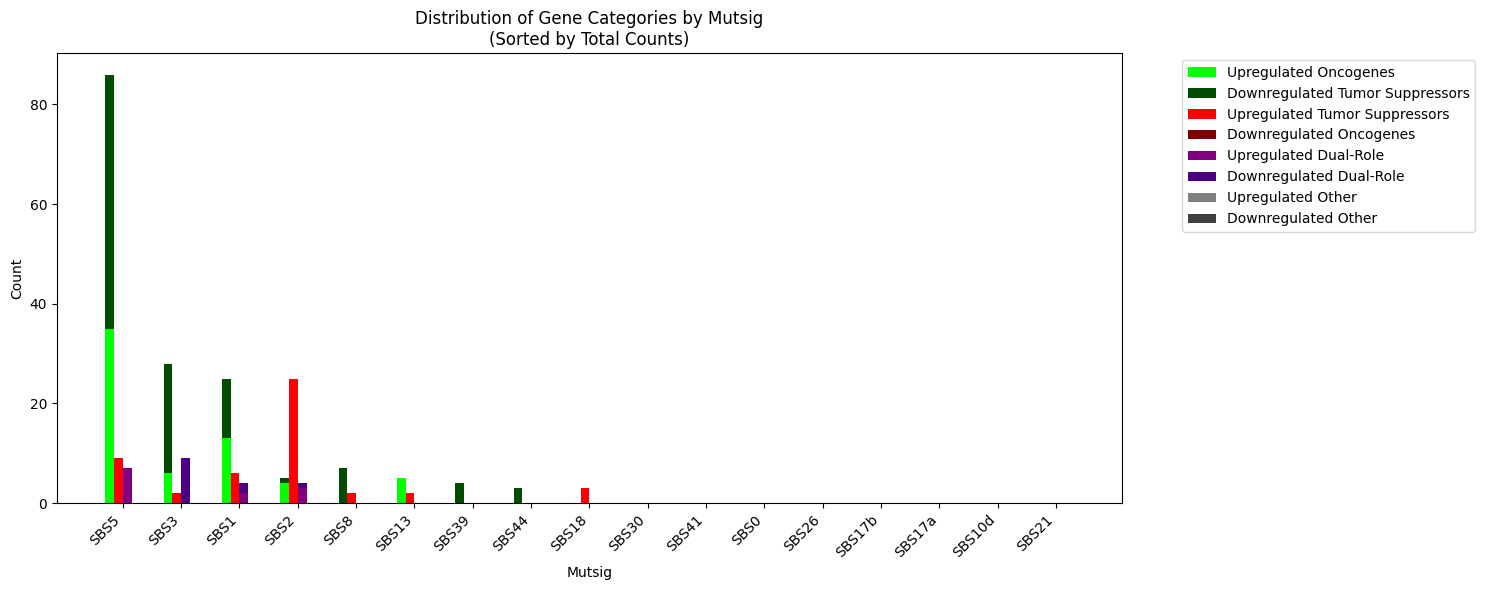

In [99]:
plot_gene_distribution(merged_df)


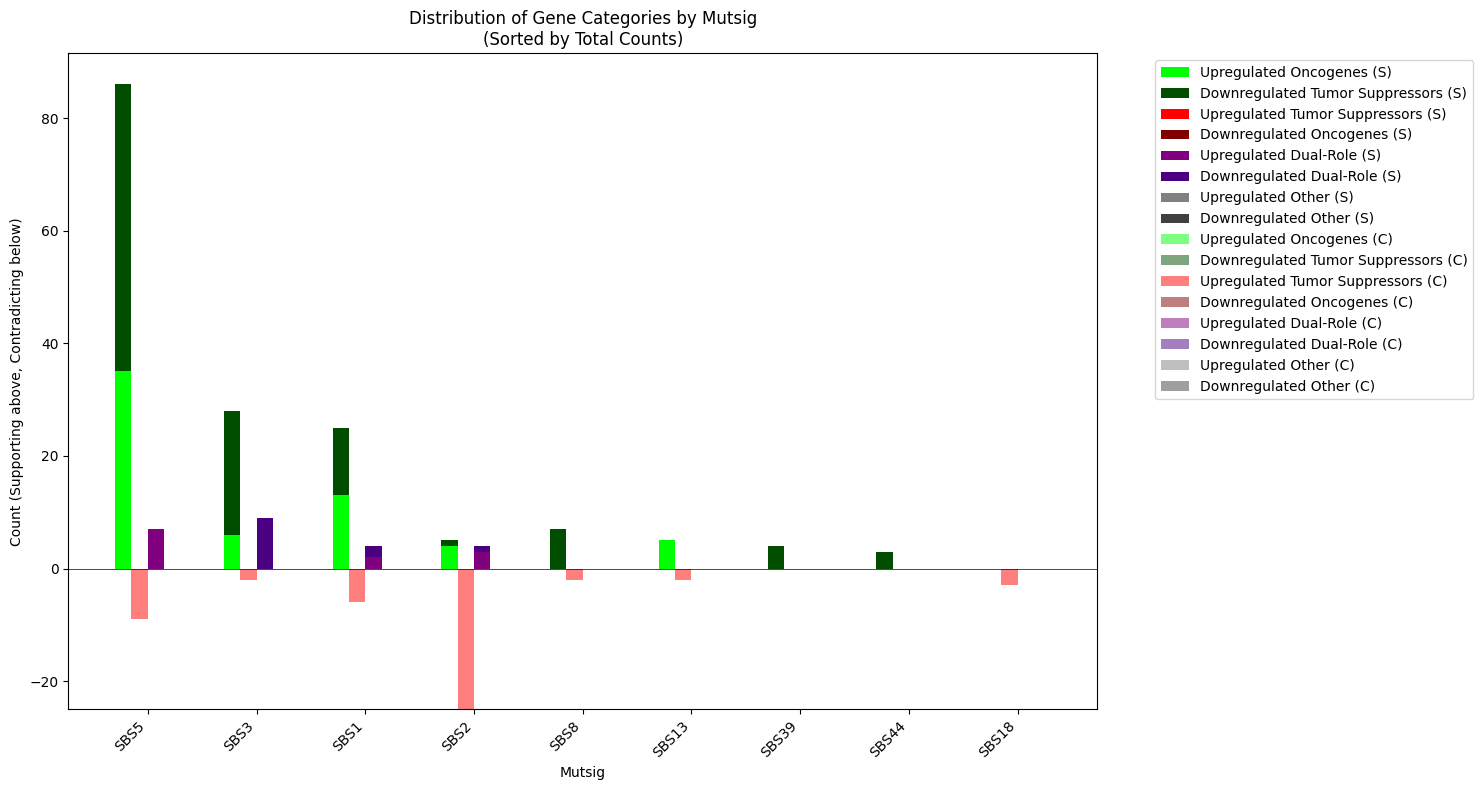

In [ ]:
# plot_gene_distribution(merged_df)
plot_mutsig_distribution_both()
# plot_mutsig_distribution_subclass()

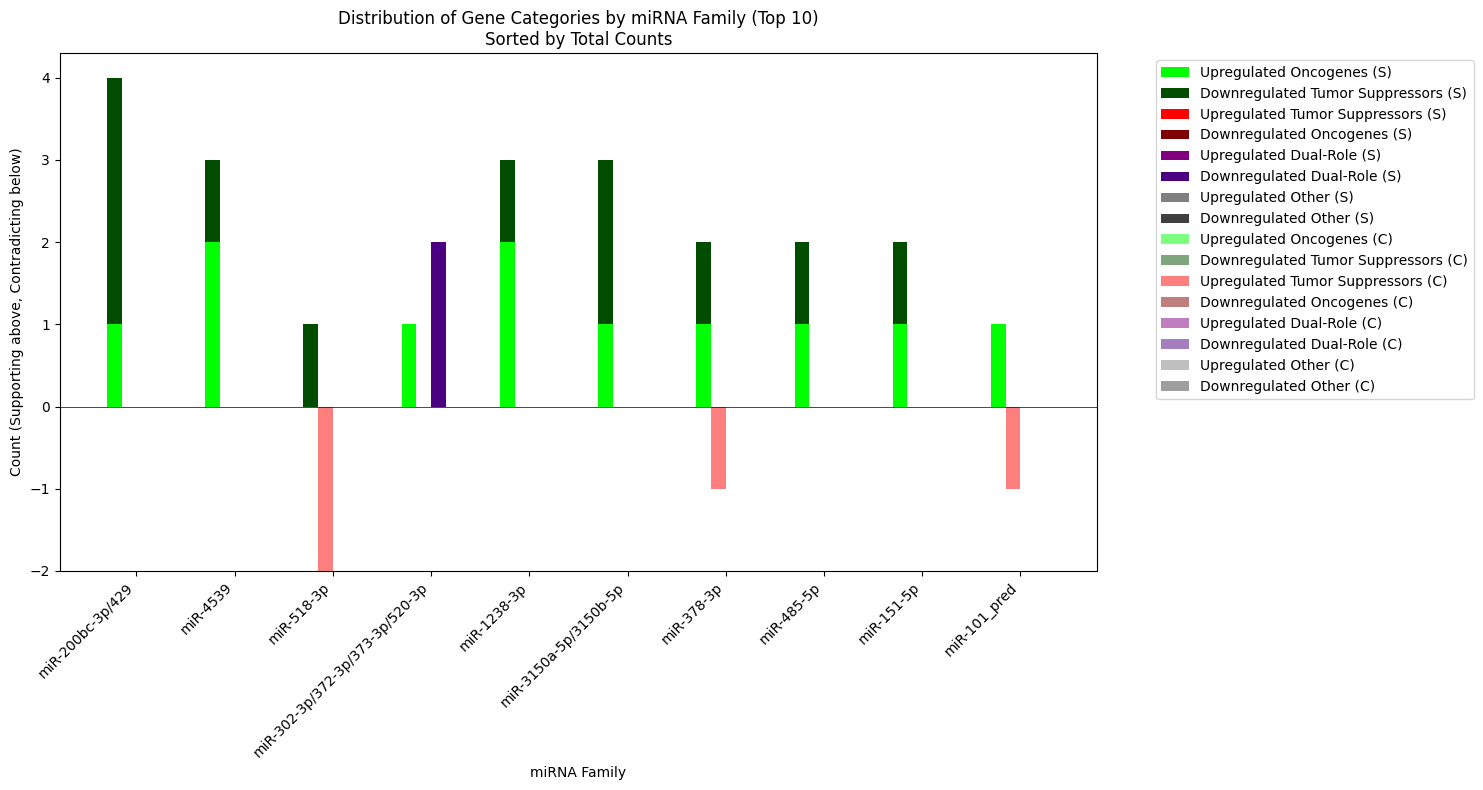

In [94]:
plot_mirna_family_distribution_both(merged_df)


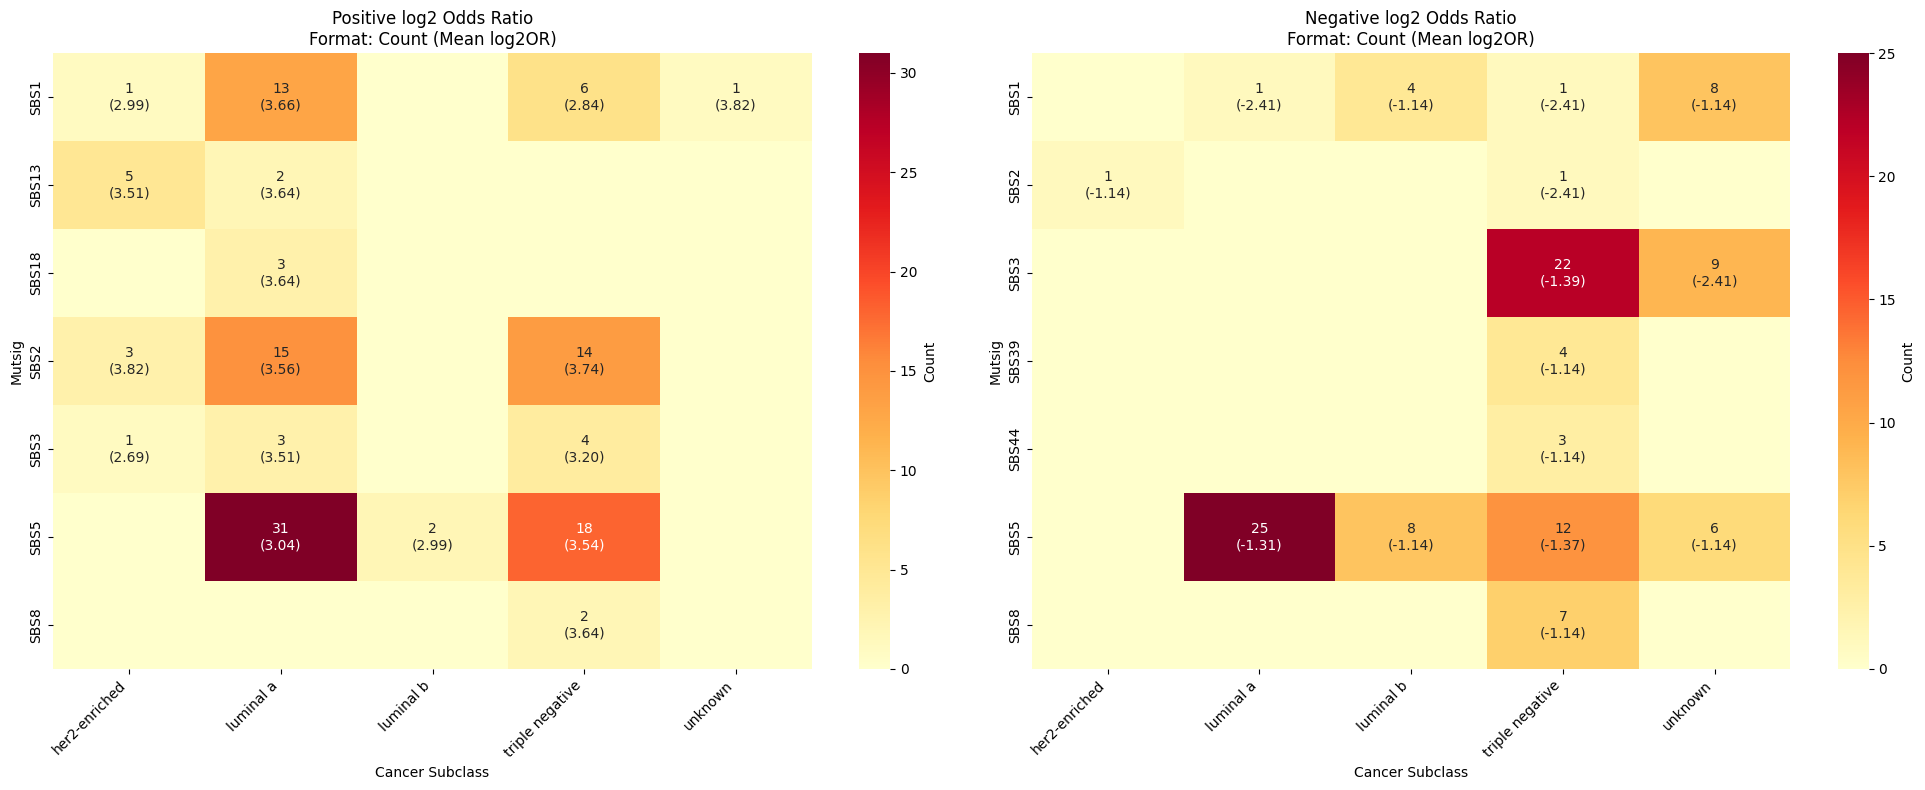

In [74]:
# Split the dataframe based on log2_odds_ratio
pos_df = merged_df[merged_df['log2_odds_ratio'] > 0]
neg_df = merged_df[merged_df['log2_odds_ratio'] < 0]

# Create count cross-tabulations
pos_counts = pd.crosstab(pos_df['mutsig'], pos_df['cancer_subclass'])
neg_counts = pd.crosstab(neg_df['mutsig'], neg_df['cancer_subclass'])

# Create mean log2_odds_ratio cross-tabulations
pos_means = pos_df.pivot_table(values='log2_odds_ratio', 
                              index='mutsig', 
                              columns='cancer_subclass', 
                              aggfunc='mean')
neg_means = neg_df.pivot_table(values='log2_odds_ratio', 
                              index='mutsig', 
                              columns='cancer_subclass', 
                              aggfunc='mean')

# Create annotation arrays combining count and mean
def create_labels(counts, means):
    labels = counts.copy()
    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            if counts.iloc[i,j] > 0:
                labels.iloc[i,j] = f'{counts.iloc[i,j]}\n({means.iloc[i,j]:.2f})'
            else:
                labels.iloc[i,j] = ''
    return labels

pos_labels = create_labels(pos_counts, pos_means)
neg_labels = create_labels(neg_counts, neg_means)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left heatmap (positive log2_odds_ratio)
sns.heatmap(pos_counts, 
            cmap='YlOrRd',
            annot=pos_labels,
            fmt='',
            cbar_kws={'label': 'Count'},
            ax=ax1)
ax1.set_title('Positive log2 Odds Ratio\nFormat: Count (Mean log2OR)')
ax1.set_xlabel('Cancer Subclass')
ax1.set_ylabel('Mutsig')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Right heatmap (negative log2_odds_ratio)
sns.heatmap(neg_counts,
            cmap='YlOrRd', 
            annot=neg_labels,
            fmt='',
            cbar_kws={'label': 'Count'},
            ax=ax2)
ax2.set_title('Negative log2 Odds Ratio\nFormat: Count (Mean log2OR)')
ax2.set_xlabel('Cancer Subclass')
ax2.set_ylabel('Mutsig')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


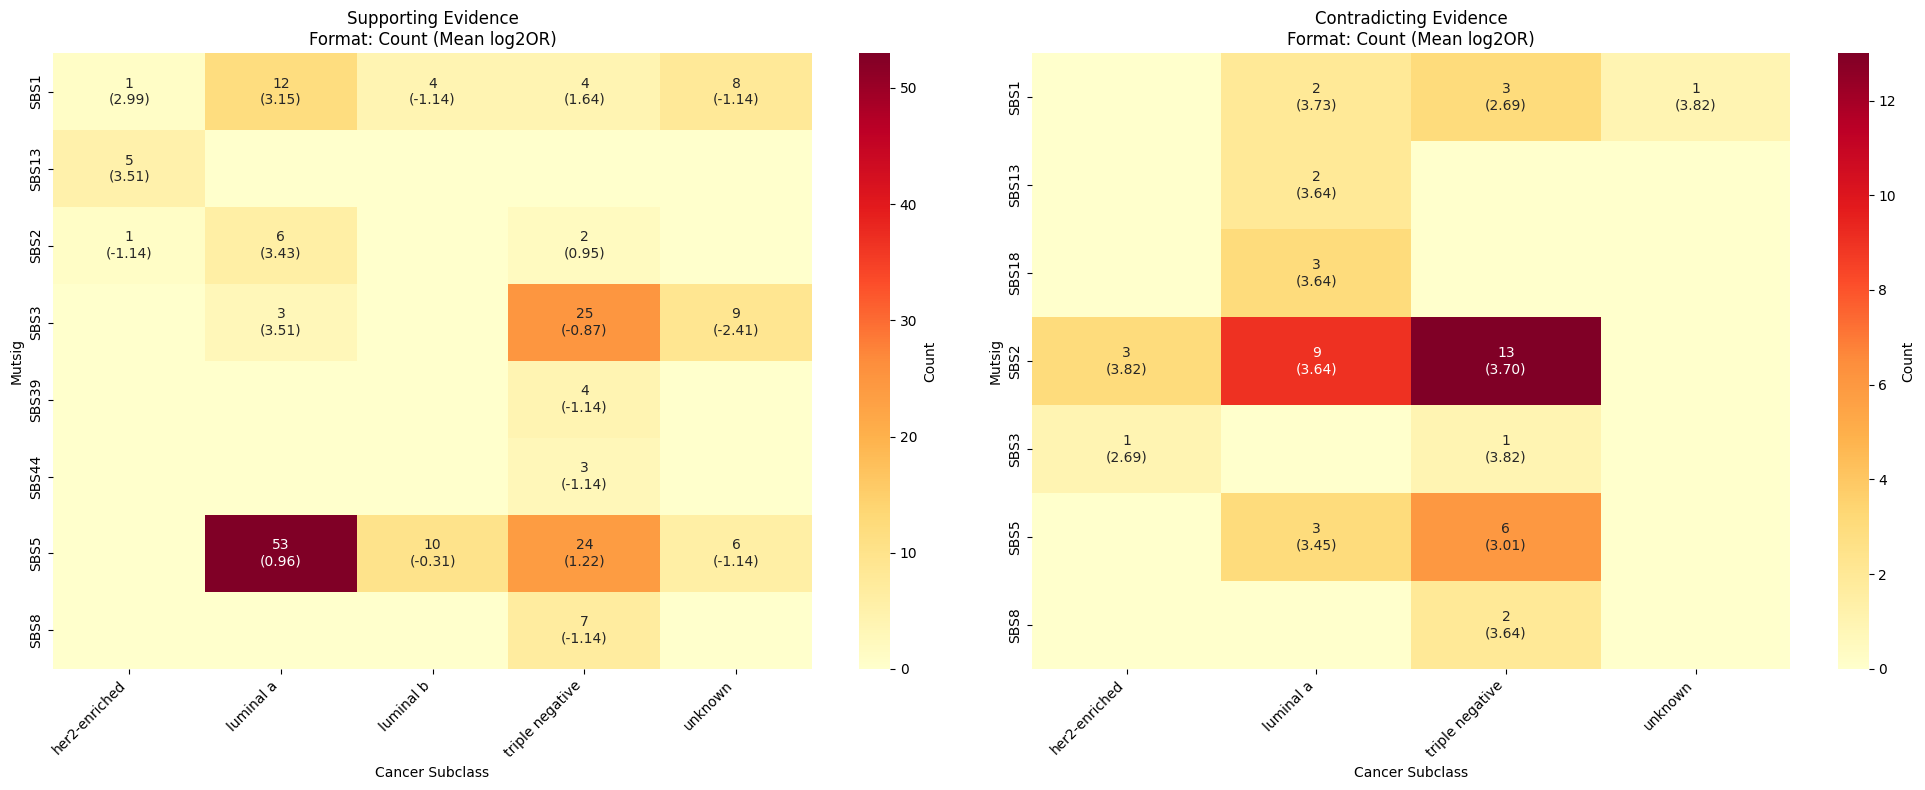

In [86]:
# Split the dataframe based on supports/contradicts
support_df = merged_df[merged_df['result'] == 'supports']
contra_df = merged_df[merged_df['result'] == 'contradicts']

# Create count cross-tabulations
support_counts = pd.crosstab(support_df['mutsig'], support_df['cancer_subclass'])
contra_counts = pd.crosstab(contra_df['mutsig'], contra_df['cancer_subclass'])

# Create mean log2_odds_ratio cross-tabulations
support_means = support_df.pivot_table(values='log2_odds_ratio', 
                                     index='mutsig', 
                                     columns='cancer_subclass', 
                                     aggfunc='mean')
contra_means = contra_df.pivot_table(values='log2_odds_ratio', 
                                   index='mutsig', 
                                   columns='cancer_subclass', 
                                   aggfunc='mean')

# Create annotation arrays combining count and mean
def create_labels(counts, means):
    labels = counts.copy()
    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            if counts.iloc[i,j] > 0:
                labels.iloc[i,j] = f'{counts.iloc[i,j]}\n({means.iloc[i,j]:.2f})'
            else:
                labels.iloc[i,j] = ''
    return labels

support_labels = create_labels(support_counts, support_means)
contra_labels = create_labels(contra_counts, contra_means)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left heatmap (supporting)
sns.heatmap(support_counts, 
            cmap='YlOrRd',
            annot=support_labels,
            fmt='',
            cbar_kws={'label': 'Count'},
            ax=ax1)
ax1.set_title('Supporting Evidence\nFormat: Count (Mean log2OR)')
ax1.set_xlabel('Cancer Subclass')
ax1.set_ylabel('Mutsig')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Right heatmap (contradicting)
sns.heatmap(contra_counts,
            cmap='YlOrRd', 
            annot=contra_labels,
            fmt='',
            cbar_kws={'label': 'Count'},
            ax=ax2)
ax2.set_title('Contradicting Evidence\nFormat: Count (Mean log2OR)')
ax2.set_xlabel('Cancer Subclass')
ax2.set_ylabel('Mutsig')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()
